In [1]:
import torch
import torch.nn as nn

import torchvision.transforms as transforms
import torch.utils.data as data_utils
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets.mnist import MNIST
from torchvision import datasets

from model import Generator, Discriminator
from train import train_DCGAN
import numpy as np
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available()  else "cpu")

In [2]:

with open("numpy_data.npy","rb") as f:
    pixels = np.load(f)


In [3]:
pixels.shape

(309, 106, 106, 1)

In [4]:
pixels = np.resize(pixels,(309,1,128 ,128))

In [5]:
pixels.shape

(309, 1, 128, 128)

In [6]:
def create_dataset(img_folder):
   
    img_data_array=[]
    class_name=[]
   
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
            image_path= os.path.join(img_folder,os.path.join(dir1, file))
            image = mpimg.imread(image_path)
            image=np.array(image)
#            img = image.astype('float32')
            
            img_data_array.append(image)
            class_name.append(dir1)
    return img_data_array, class_name
# extract the image array and class name
img_data, _ =create_dataset('./CAN_models/image_data/')

NameError: name 'os' is not defined

In [ ]:
img_data[0].shape 

In [ ]:
plt.imshow(img_data[0])

In [ ]:
import torchvision
from PIL import Image
np_pil_im_arr=[]
for i in range(np.array(img_data).shape[0]):
    new_im = Image.fromarray(img_data[i])
    #x = torchvision.transforms.functional.resized_crop(new_im,i=1,j=7,h=99, w=99,size=(99,99))
    x=torchvision.transforms.functional.pad(new_im,(28,22,0,0),fill=0)
    np_pil_im_arr.append(np.array(x))

In [ ]:
np_pil_im_arr[0].shape

In [ ]:
len(np_pil_im_arr)

In [ ]:
plt.imshow(np_pil_im_arr[0])

In [ ]:
plt.figure(figsize=(20,20))
test_folder='./image_data/albeniz/'
for i in range(3):
    ax=plt.subplot(1,3,i+1)
    plt.imshow(np.array(np_pil_im_arr[i]))


In [ ]:
img_data=np.resize(np_pil_im_arr,(295,1,128,128))

In [ ]:
img_data.shape

In [ ]:
# trans = transforms.Compose([
#             transforms.Scale(128),
#             transforms.ToTensor(),
#             transforms.Normalize((0.5, ), (0.5, )),
#         ])
# path = r'C:\Users\Monalisha\Desktop\generative modelling\project'
# dataset = datasets.ImageFolder(path, transform=trans)

In [ ]:
dataset = torch.from_numpy(img_data)

In [ ]:
dataset.size()

In [ ]:
g_lr = 0.00002
d_lr = 0.0000002
batch_size = 28
num_epochs = 73

In [ ]:

#train_set = MNIST(root='.', train=True, transform=trans, download=True)
train_loader = data_utils.DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [ ]:


G = Generator().to(device)
D = Discriminator().to(device)

optim_G = torch.optim.Adam(G.parameters(), lr=g_lr, betas=(0.05, 0.999))
optim_D = torch.optim.Adam(D.parameters(), lr=d_lr, betas=(0.05, 0.999))

loss_f = nn.BCELoss()

train_DCGAN(G, D, optim_G, optim_D, loss_f, train_loader, num_epochs, device)

In [ ]:
from torchvision.utils import make_grid
noise = torch.randn(1, 100, device=device)
img_fake = G(noise)
grid = make_grid(img_fake)
plt.imshow(grid.permute(1, 2, 0).detach().cpu().numpy())
plt.show()

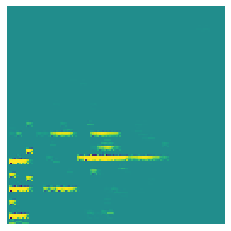

In [18]:
plt.axis('off')
plt.imshow(img_fake[0][0].detach().cpu().numpy())
plt.savefig('GeneratedJazz1.png', bbox_inches=0, pad_inches=0, transparent=False)

In [ ]:
from PIL import Image
import numpy as np
from music21 import instrument, note, chord, stream

lowerBoundNote = 21
def column2notes(column):
    notes = []
    for i in range(len(column)):
        if column[i] > 255/2:
            notes.append(i+lowerBoundNote)
    return notes

resolution = 0.25
def updateNotes(newNotes,prevNotes): 
    res = {} 
    for note in newNotes:
        if note in prevNotes:
            res[note] = prevNotes[note] + resolution
        else:
            res[note] = resolution
    return res

def image2midi(image_path):
    with Image.open(image_path) as image:
        im_arr = np.fromstring(image.tobytes(), dtype=np.uint8)
        try:
            im_arr = im_arr.reshape((384, 432,3))
        except:
            im_arr = im_arr.reshape((image.size[1], image.size[0],3))
            im_arr = np.dot(im_arr, [0.33, 0.33, 0.33])

    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model

    prev_notes = updateNotes(im_arr.T[0,:],{})
    for column in im_arr.T[1:,:]:
        notes = column2notes(column)
        # pattern is a chord
        notes_in_chord = notes
        old_notes = prev_notes.keys()
        for old_note in old_notes:
            if not old_note in notes_in_chord:
                new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
                new_note.storedInstrument = instrument.Piano()
                if offset - prev_notes[old_note] >= 0:
                    new_note.offset = offset - prev_notes[old_note]
                    output_notes.append(new_note)
                elif offset == 0:
                    new_note.offset = offset
                    output_notes.append(new_note)                    
                else:
                    print(offset,prev_notes[old_note],old_note)

        prev_notes = updateNotes(notes_in_chord,prev_notes)

        # increase offset each iteration so that notes do not stack
        offset += resolution

    for old_note in prev_notes.keys():
        new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
        new_note.storedInstrument = instrument.Piano()
        new_note.offset = offset - prev_notes[old_note]

        output_notes.append(new_note)

    prev_notes = updateNotes(notes_in_chord,prev_notes)

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=image_path.split("/")[-1].replace(".png",".mid"))

import sys
image_path = './GeneratedJazz0.png'
image2midi(image_path)

In [ ]:
377110/(288*432)

In [ ]:
497664/432/384

In [ ]:
128*3